In [1]:
# !pip install "torch==1.4" "torchvision==0.5.0"

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

My aim is to create the backend for my web app to form a Pokedex. This classifier will only classify the orginal Pokemons! That is it will only be able to distinguish the first 150 Pokemons made. These include Pikachu, Squirtle, and even MewTwo!

# Load Data From Kaggle API

I got my [dataset](https://www.kaggle.com/lantian773030/pokemonclassification) from the Kaggle user Lance Zhang. <br>
There are around 25 - 50 images for each Pokemon. All of them with the Pokemon in the center. Most (if not all) of the images have relatively high quality (correct labels, centered).



In [2]:
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600/root/.kaggle/kaggle.json

In [6]:
# !kaggle datasets download -d lantian773030/pokemonclassification
# !unzip pokemonclassification.zip 
# !mv dataset/dataset extra

# Load Libraries

In [99]:
from fastai.vision import *
from fastai.imports import *
from PIL import Image

# Show Data

In [5]:
path = Path('/content/PokemonData')

In [7]:
files = path.ls()
files[:5]

[PosixPath('/content/PokemonData/Shellder'),
 PosixPath('/content/PokemonData/Marowak'),
 PosixPath('/content/PokemonData/Oddish'),
 PosixPath('/content/PokemonData/Alolan Sandslash'),
 PosixPath('/content/PokemonData/Butterfree')]

The FastAI library does not work with .svg images, which is why I have removed them from the dataset.

In [8]:
for file in files:
  for i in file.ls():
    if(i.suffix == '.svg'):
      !rm {i}

Using the DataBlock API, I create my main starting file. I have kept two separate variables src and data as I want to apply Image Progession to the dataset.

In [9]:
np.random.seed(42)

src = (ImageList.from_folder(path)
      .split_by_rand_pct(0.1)
      .label_from_folder())

In [10]:
size = np.array([128,128])
bs = 64

In [11]:
data = (src.transform(get_transforms(max_rotate=1.05), size = size)
          .databunch(bs=bs)
          .normalize(imagenet_stats))

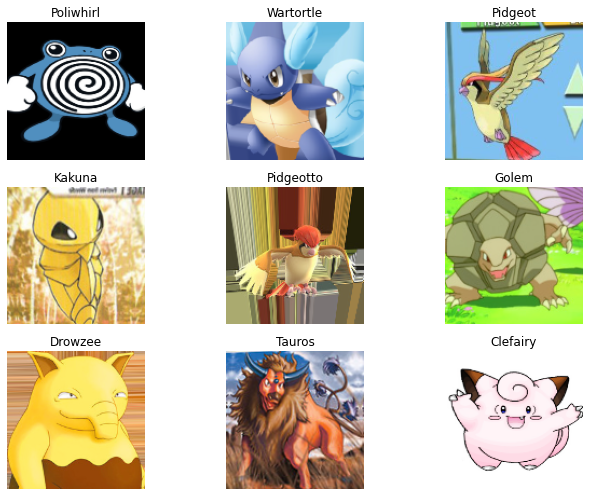

In [12]:
data.show_batch(3, figsize=(10,7))

In [13]:
learner = cnn_learner(data, models.resnet50, metrics = accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


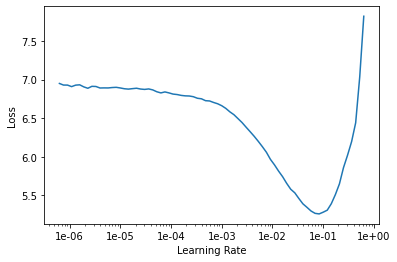

In [14]:
learner.lr_find()
learner.recorder.plot()

In [15]:
lr = 1e-02

In [16]:
learner.fit_one_cycle(10, slice(lr))

In [17]:
learner.save('model-1')

In [23]:
learner.load('model-1');

In [24]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


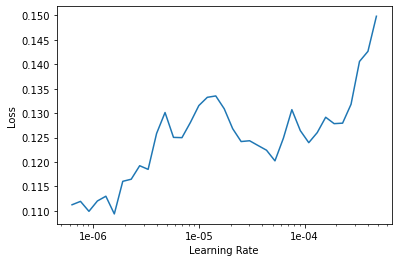

In [25]:
learner.lr_find()
learner.recorder.plot()

In [26]:
learner.fit_one_cycle(10, slice(lr/1000, lr/100))

In [27]:
learner.save('model-2')

In [28]:
data = (src.transform(get_transforms(max_rotate=1.05), size = size*2)
          .databunch(bs=bs//2)
          .normalize(imagenet_stats))

In [29]:
learner = cnn_learner(data, models.resnet50, metrics = accuracy)

In [30]:
learner.load('model-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


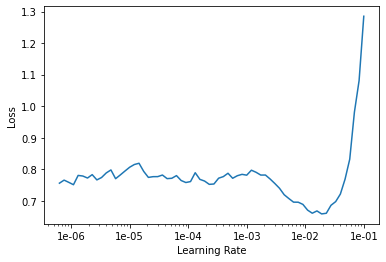

In [31]:
learner.lr_find()
learner.recorder.plot()

In [32]:
lr = 1e-02/2

In [33]:
learner.fit_one_cycle(7, slice(lr))

In [36]:
learner.save('model-1-big')

In [47]:
learner.load('model-1-big');

In [48]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


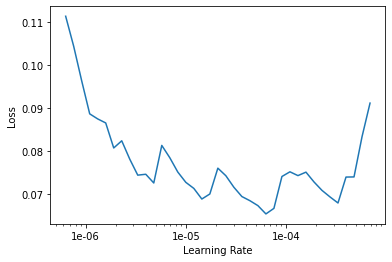

In [49]:
learner.lr_find()
learner.recorder.plot()

In [50]:
learner.fit_one_cycle(10, slice(1e-06/2, lr/100))

In [62]:
learner.save('model-2-big')

In [72]:
learner.export()

In [54]:
interp = ClassificationInterpretation.from_learner(learner)

In [58]:
interp.most_confused(min_val = 2)

[('Kingler', 'Krabby', 3), ('Grimer', 'Muk', 2), ('Primeape', 'Mankey', 2)]

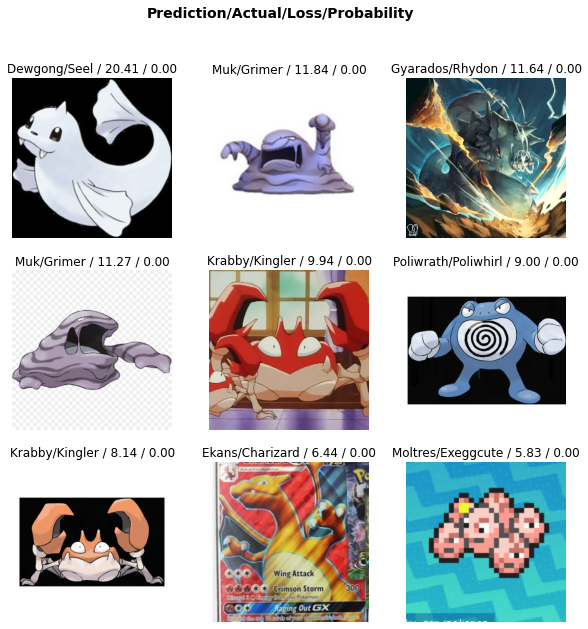

In [56]:
interp.plot_top_losses(9, figsize=(10,10))

If you look carefully, the maximum error has occured in classifiying two species of the same family, but different evolution stages! <br>
This means that even though the categorization is wrong, it still understands that it belongs to the same family. <br>
For example, Muk and Grimer look almost exactly the same. Krabby and Kingler only have a difference of an extra thorn. The same applies for Dewgong and Seel. <br>
Hence, after analyzing where it went wrong, I can say confidently that I trust the model.

In [59]:
defaults.device = torch.device('cpu')

In [83]:
cls = data.classes

In [73]:
data2 = ImageDataBunch.single_from_classes(
    path, 
    data.classes, 
    ds_tfms = get_transforms(),
    size = 224
).normalize(imagenet_stats)
learn = cnn_learner(data2, models.resnet50, metrics = accuracy)
learn.load('model-2-big');

In [74]:
learn = load_learner(path)

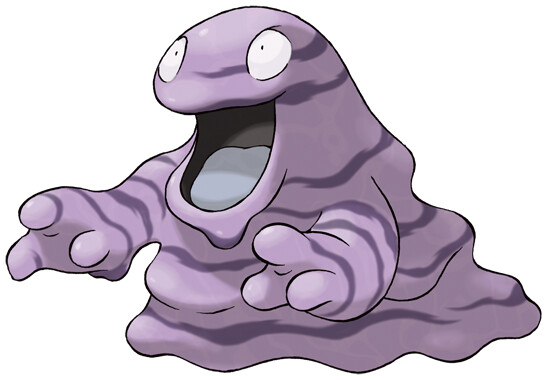

In [98]:
img = open_image('/content/Grimer.jpg')
pred_class,pred_idx,outputs = learn.predict(img)
cls[pred_idx]
img

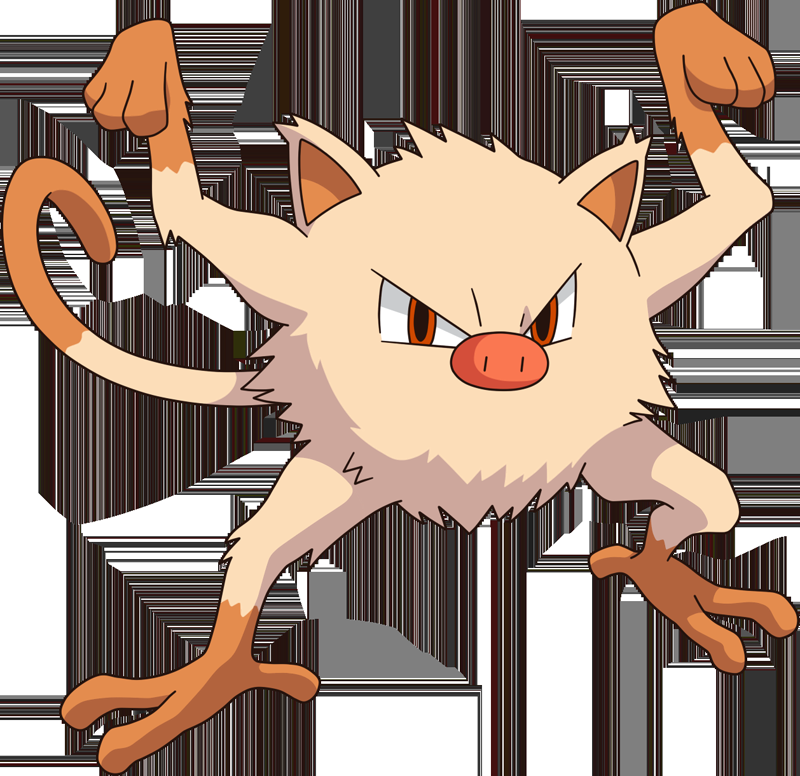

In [93]:
img = open_image('/content/mankey.png')
pred_class,pred_idx,outputs = learn.predict(img)
cls[pred_idx]
img

Mewtwo


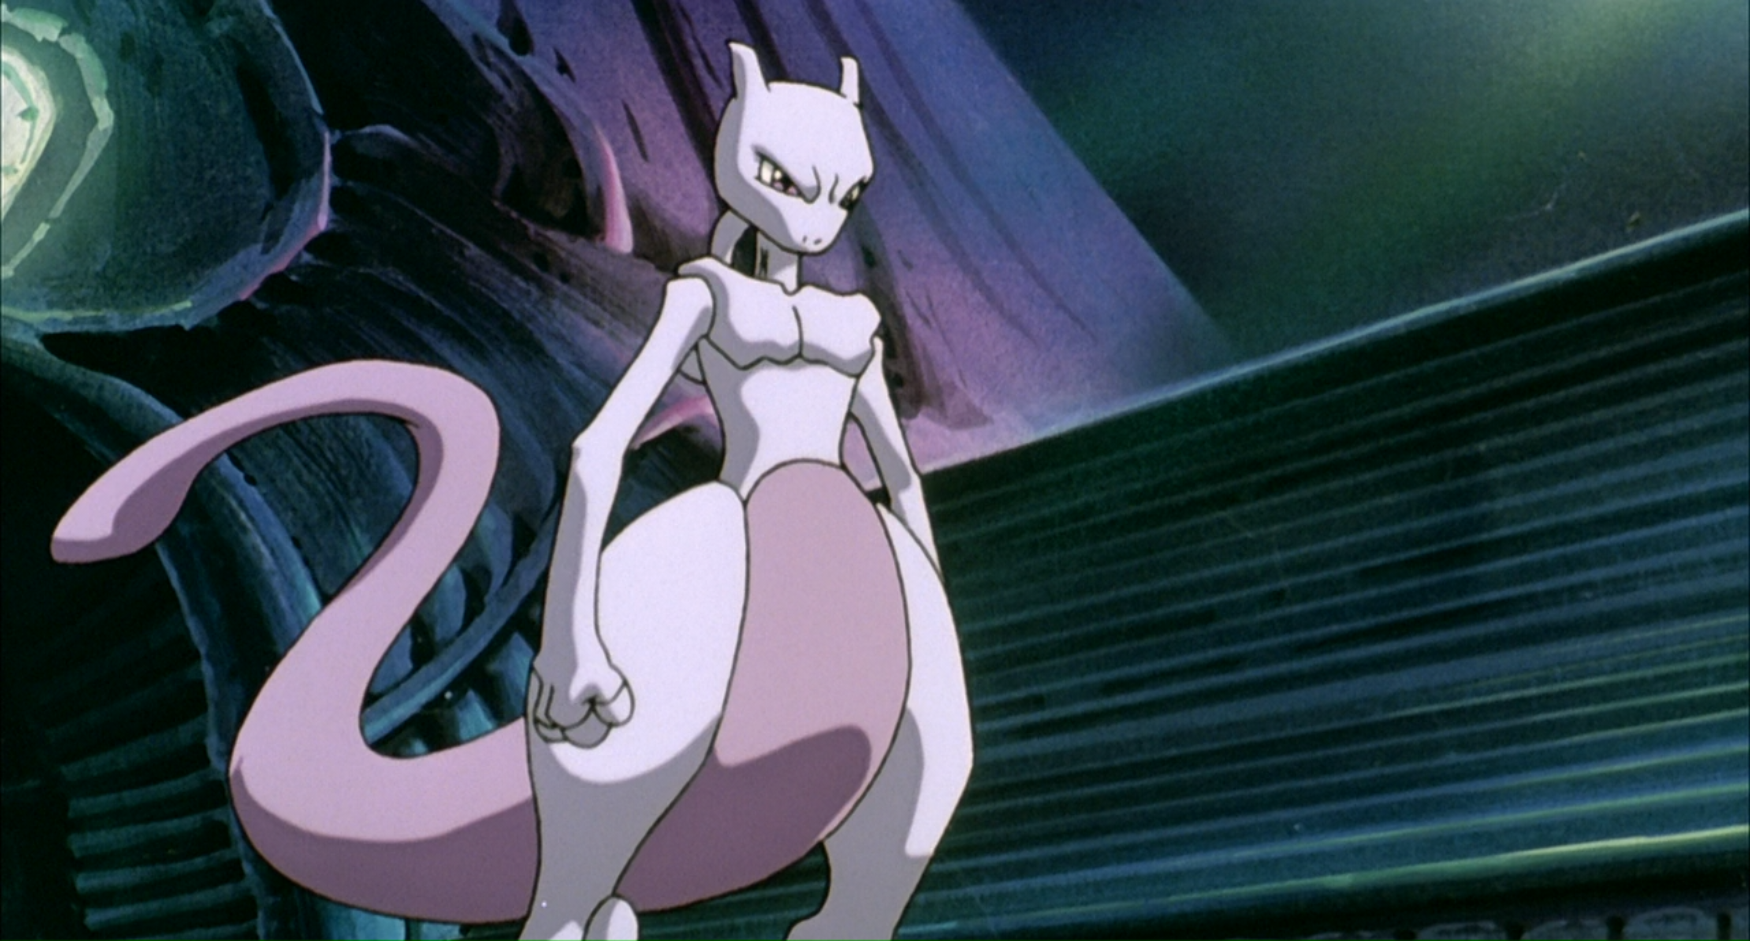

In [92]:
img = open_image('/content/mewtwo.png')
pred_class,pred_idx,outputs = learn.predict(img)
print(cls[pred_idx])
img